# Calculating the ***S***ecular ***H***eritability ***EST***imate (SHEST)  



### Import Statements

In [1]:
import gspread
import os
import pylab
import math

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from google.colab import files
from scipy.optimize import curve_fit
from numpy.linalg import lstsq
from google.colab import drive

plt.style.use("seaborn")

### Access Data

For information on how the csv files should be formatted, see the README.md file in https://github.com/relhajj/SHEST-heritability.

In [ ]:
# mount google drive
drive.mount('/gdrive')

In [ ]:
# change directory to where the csvs are kept
%cd /gdrive/Shared drives/BIOIN 401 Heritability/notebooks/csvs

### Function Definitions 

In [5]:
def fit_line(phenotype, header, ylabel, adj):
    # guide: fit_line(column name as found in dataframe, 
    #                 graph title (phenotype name), 
    #                 data description (e.g., Incidence / 100000),
    #                 y axis maximum adjustment to make graph look better)

    # get data
    
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    eqn_slope = np.polyfit(xdata, ydata, 1)

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3fx + %.3f"%(eqn_slope[0], eqn_slope[1]), "\n")

    print("H_min: %.3f" % min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))
    print("H_max: %.3f" % max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1]))

    print("H^2: %.3f" % (min(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])/max(eqn_slope[0]*min(xdata)+eqn_slope[1],eqn_slope[0]*max(xdata)+eqn_slope[1])))
    print()

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data')
    plt.title(header, fontdict = {'fontsize' : 20})
    plt.xlabel("Year", fontdict = {'fontsize' : 20})
    plt.ylabel(header+" "+ylabel)
    plt.ylabel(ylabel, fontdict = {'fontsize' : 20})
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))
    plt.plot(xdata, [x*eqn_slope[0]+eqn_slope[1] for x in xdata], color="green")
    plt.show()

    return eqn_slope

def fit_test(phenotype):
    # guide: fit_line(column name as found in dataframe, 
    #                 graph title (phenotype name), 
    #                 data description (e.g., Incidence / 100000),
    #                 y axis maximum adjustment to make graph look better)

    # get data
    
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    eqn_slope = np.polyfit(xdata, ydata, 1)

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata)
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)))
    plt.show()

    return eqn_slope

def sigmoid(x, L ,x0, k, b): 
    # sigmoid equation
    
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def fit_sigmoid(phenotype, header, ylabel, adj):
    # guide: fit_sigmoid(column name as found in dataframe, 
    #                    graph title (phenotype name), 
    #                    data description (e.g., Incidence / 100000),
    #                    y axis maximum adjustment to make graph look better)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    p0 = [max(ydata), np.median(xdata),1,min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("Equation: %.3f / (1 + e^(-%.3f*(x - %.3f))) + %.3f" % (popt[0], popt[1], popt[2], popt[3]), "\n")

    print("H_min: %.3f" % min(popt[3], (popt[0]+popt[3])))
    print("H_max: %.3f" % max(popt[3], (popt[0]+popt[3])))

    print("H^2: %.3f" % (min(popt[3]/(popt[0]+popt[3]),(popt[0]+popt[3])/popt[3])))
    print()

    x = np.linspace(min(xdata), max(xdata))
    y = sigmoid(x, *popt)

    ax = pylab.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.title(header, fontdict = {'fontsize' : 20})
    pylab.xlabel("Year", fontdict = {'fontsize' : 20})
    pylab.ylabel(header+" "+ylabel)
    pylab.ylabel(ylabel, fontdict = {'fontsize' : 20})
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))
    pylab.plot(xdata, ydata, 'o')
    pylab.plot(x, y)
    pylab.show()

    return popt

ramp = lambda u: np.maximum( u, 0 )
step = lambda u: ( u > 0 ).astype(float)

def SegmentedLinearReg( X, Y, breakpoints ):
    nIterationMax = 10

    breakpoints = np.sort( np.array(breakpoints) )

    dt = np.min( np.diff(X) )
    ones = np.ones_like(X)

    for i in range( nIterationMax ):
        # Linear regression:  solve A*p = Y
        Rk = [ramp( X - xk ) for xk in breakpoints ]
        Sk = [step( X - xk ) for xk in breakpoints ]
        A = np.array([ ones, X ] + Rk + Sk )
        p =  lstsq(A.transpose(), Y, rcond=None)[0] 

        # Parameters identification:
        a, b = p[0:2]
        ck = p[ 2:2+len(breakpoints) ]
        dk = p[ 2+len(breakpoints): ]

        # Estimation of the next break-points:
        newBreakpoints = breakpoints - dk/ck 

        # Stop condition
        if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
            break

        breakpoints = newBreakpoints
    else:
        print( 'maximum iteration reached' )

    # Compute the final segmented fit:
    Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
    ones =  np.ones_like(Xsolution) 
    Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

    Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )

    return Xsolution, Ysolution

def fit_segmented(phenotype, header, ylabel, adj, initialBreakpoints):
    # guide: fit_segmented(column name as found in dataframe, 
    #                      graph title (phenotype name), 
    #                      data description (e.g., Incidence / 100000),
    #                      y axis maximum adjustment to make graph look better,
    #                      list of years where the data seems to change)

    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    x_sol, y_sol = SegmentedLinearReg(xdata, ydata, initialBreakpoints)

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    print("H_min: %.3f" % min(y_sol))
    print("H_max: %.3f" % max(y_sol))

    print("H^2: %.3f" % (min(y_sol)/max(y_sol)))
    print()

    plt.figure(figsize=(8,5)) 
    plt.plot(xdata, ydata, 'o')
    plt.xlabel("Year", fontdict = {'fontsize' : 20})
    plt.ylabel(header+" "+ylabel)
    plt.ylabel(ylabel, fontdict = {'fontsize' : 20})
    plt.title(header, fontdict = {'fontsize' : 20})
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))
    plt.plot( *SegmentedLinearReg(xdata, ydata, initialBreakpoints ), '-' )

    return SegmentedLinearReg(xdata, ydata, initialBreakpoints)

def minmax_time(phenotype, header, ylabel, xlabel, adj):
    xdata = [i for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    fig, ax = plt.subplots(figsize=(8,5))    

    plt.bar(xdata, ydata)

    for i, v in enumerate(ydata):
        ax.text(i - len(xdata)*(0.02), v + 0.02*max(ydata), str(round(v,2)), color='black')

    plt.title(header, fontdict = {'fontsize' : 20})

    plt.xlabel(xlabel, fontdict = {'fontsize' : 20})
    plt.ylabel(header+" "+ylabel)
    plt.ylabel(ylabel, fontdict = {'fontsize' : 20})

    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))

    plt.show()

def scatter(phenotype, header, ylabel, adj):
 
    # get data
    xdata = [float(i) for i in df[phenotype].dropna().index[0:-1]]
    ydata = [float(i) for i in df[phenotype].dropna()[0:-1]]

    print("Min year:", int(min(xdata)))
    print("Max year:", int(max(xdata)), "\n")

    print("Min Inc/Prev: %.3f" % min(ydata))
    print("Max Inc/Prev: %.3f" % max(ydata), "\n")

    ax = plt.figure(figsize=(8,5)).gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.scatter(xdata, ydata, label='data')
    plt.title(header, fontdict = {'fontsize' : 20})
    plt.xlabel("Year", fontdict = {'fontsize' : 20})
    plt.ylabel(header+" "+ylabel)
    plt.ylabel(ylabel, fontdict = {'fontsize' : 20})
    plt.ylim(ymin=0, ymax=(max(ydata)+min(ydata)+adj))
    plt.show()

    

### Create dataframe with all the conditions

In [ ]:
df = pd.DataFrame(data=[])

for filename in sorted(os.listdir(".")):
  print(filename)
  df_inc = pd.read_csv(filename, index_col=0)
  df_inc = df_inc[~df_inc.index.duplicated()]
  # print(df_inc.index.duplicated().any())
  df = df.merge(df_inc, how='outer', left_index=True, right_index=True)

df.columns

### Calculate SHEST coefficient for different diseases, conditions and phenotypes

To calculate a SHEST coefficient, simply call the relevant function. The possible functions to call are:
*   fit_line()
*   fit_sigmoid()
*   fit_seqmented()
*   scatter()
*   minmax_time()

For examples of how to call each function, see Example 1 to Example 5 below.


Example 1: Linear


Min year: 1996
Max year: 2016 

Min Inc/Prev: 29.044
Max Inc/Prev: 42.962 

Equation: -0.006x + 46.593 

H_min: 34.654
H_max: 34.773
H^2: 0.997



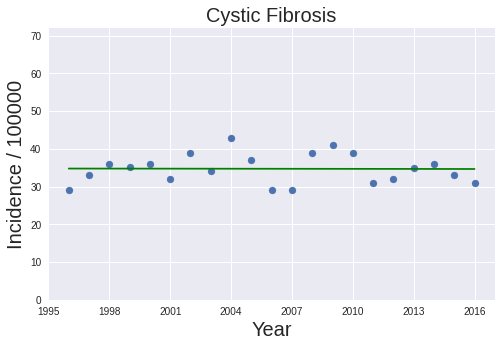

array([-5.92215644e-03,  4.65932890e+01])

In [20]:
fit_line("cf", "Cystic Fibrosis", "Incidence / 100000", 0)

Example 2: Sigmoid

Min year: 1895
Max year: 1975 

Min Inc/Prev: 2.174
Max Inc/Prev: 12.350 

Equation: 9.239 / (1 + e^(-1928.161*(x - 0.149))) + 2.485 

H_min: 2.485
H_max: 11.724
H^2: 0.212



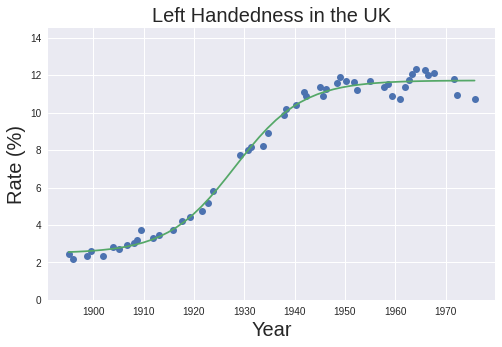

array([9.23878999e+00, 1.92816147e+03, 1.48977292e-01, 2.48480066e+00])

In [19]:
fit_sigmoid("left_handedness_uk", "Left Handedness in the UK", "Rate (%)", 0)

Example 3: Segmented 

Min year: 1966
Max year: 2003 

Min Inc/Prev: 0.144
Max Inc/Prev: 1.470 

H_min: 0.158
H_max: 1.383
H^2: 0.114



(array([1966.        , 1983.05057348, 2003.        ]),
 array([0.15816608, 1.38291758, 1.14331641]))

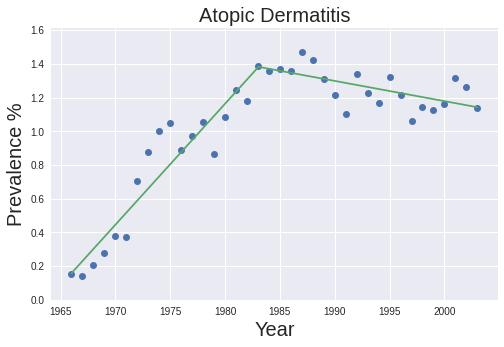

In [21]:
fit_segmented("atopic_dermatitis_2", "Atopic Dermatitis", "Prevalence %", 0, [1982])

Example 4: Raw, Scatter 

Min year: 1910
Max year: 2019 

Min Inc/Prev: 0.000
Max Inc/Prev: 57879.000 



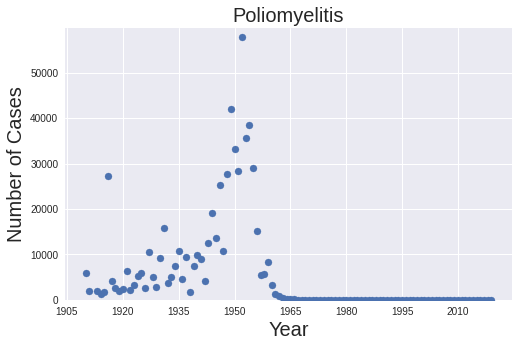

In [8]:
scatter("polio_scatter", "Poliomyelitis", "Number of Cases", 2000)

Example 5: Raw, min/max 

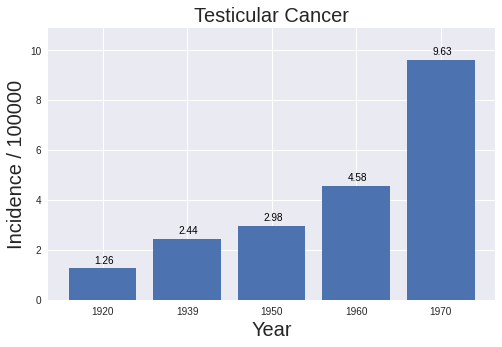

In [17]:
minmax_time("testicular_cancer_2.0", "Testicular Cancer", "Incidence / 100000", "Year", 0)